In [52]:
import pandas as pd
import numpy as np
from igraph import Graph

## Obtain Communities

In [25]:
# Function to obatain fastgreedy communities
def get_fastgreedy_communities(net):
    g = Graph.Load(net)
    dendrogram = g.community_fastgreedy(weights="weight")
    clusters = dendrogram.as_clustering()
    return g, clusters

In [26]:
# Build dataframe communities
def format_communities(g, clusters):
    
    def check_seller_role(row):
        if '_seller' in row['club_name']:
            row['club_name'] = row['club_name'].replace('_seller', '')
            row['role'] = 'seller'
        else:
            row['role'] = 'buyer'
        return row
    
    df_clusters = pd.DataFrame()
    for i, cluster in enumerate(clusters):
        cluster_idx = [i for c in cluster]
        club_name = [g.vs[c]["name"] for c in cluster]
        df_aux = pd.DataFrame({'cluster_idx': cluster_idx, 'club_name': club_name})
        df_clusters = pd.concat([df_clusters, df_aux])
    
    # Add league information
    df_league = pd.read_csv('resources/club_league.csv')
    df_league_sellers = df_league.copy()
    df_league_sellers['club_name'] = df_league_sellers['club_name'] + '_seller'
    df_clusters = pd.merge(df_clusters, df_league, how='left', on='club_name')
    df_clusters = pd.merge(df_clusters, df_league_sellers, how='left', on='club_name')
    df_clusters['league_name'] = df_clusters['league_name_x'].fillna(df_clusters['league_name_y'])
    df_clusters.drop(columns=['league_name_x', 'league_name_y'], inplace=True)
    
    df_clusters = df_clusters.apply(check_seller_role, axis=1)
    return df_clusters

In [27]:
# Get cluster's league composition
def get_league_composition(df_clusters):
    df_clusters_stats = df_clusters.groupby(['cluster_idx', 'role','league_name']).club_name.count().reset_index()
    return df_clusters_stats

In [164]:
def filter_small_clusters(df_cluster_stats, min_clubs):
    df_cluster_stats_aux = df_cluster_stats[df_cluster_stats['role'] == 'buyer'].groupby('cluster_idx').club_name.sum().reset_index()
    df_cluster_stats_aux = df_cluster_stats_aux[df_cluster_stats_aux['club_name'] >= min_clubs]
    df_cluster_stats = pd.merge(df_cluster_stats, df_cluster_stats_aux[['cluster_idx']], how='inner', on='cluster_idx')
    return df_cluster_stats

In [165]:
# Do all function
def get_communities(net):
    g, clusters = get_fastgreedy_communities(net)
    df_clusters = format_communities(g, clusters)
    df_cluster_stats = get_league_composition(df_clusters)
    df_cluster_stats = filter_small_clusters(df_cluster_stats, 8)
    return df_clusters, df_cluster_stats

In [306]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import cm

cdict = {'Premier League': 'royalblue', 'Primera Division': 'forestgreen', 'Serie A': 'orange', '1 Bundesliga': 'red',
         'Ligue 1': 'hotpink', 'Liga Nos': 'peachpuff', 'Eredivisie': 'gold', 'Premier Liga': 'cornflowerblue',
         'Austria': 'darkseagreen', 'Belgium': 'mediumorchid', 'Argentina': 'deepskyblue', 'Brazil': 'yellow',
         'Chile': 'lightsalmon', 'Croatia': 'pink', 'Denmark': 'lightcyan', 'Greece': 'aqua', 'Hungary': 'olive',
         'Mexico': 'yellowgreen', 'Norway': 'silver', 'Polonia': 'linen', 'Romania': 'navajowhite',
         'Scotland': 'lavender', 'Serbia': 'maroon', 'Sweden': 'cornsilk', 'Switzerland': 'honeydew',
         'Turkey': 'tan', 'Ukraine': 'mintcream', 'Uruguay': 'powderblue', 'Usa': 'dimgrey', 'Other': 'black'}

def get_pie_chart_data(df_cluster_stats, cluster, role):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = df_cluster_stats[(df_cluster_stats['cluster_idx'] == cluster) &
                              (df_cluster_stats['role'] == role)]['league_name'].unique().tolist()
    all_clubs = df_cluster_stats[(df_cluster_stats['cluster_idx'] == cluster) &
                                 (df_cluster_stats['role'] == role)].club_name.sum()
    df_cluster_stats['perc'] = 100*df_cluster_stats['club_name']/all_clubs
    sizes = df_cluster_stats[(df_cluster_stats['cluster_idx'] == cluster) &
                             (df_cluster_stats['role'] == role)]['perc'].tolist()
    
    # Obtain explode slice
    max_size_idx = sizes.index(max(sizes))
    aux = np.zeros(len(sizes))
    aux[max_size_idx] = 0.1
    explode = tuple(list(aux))
    
    return labels, sizes, explode

def get_pie_chart_plot(df_cluster, df_cluster_stats):
    cluster_list = df_cluster_stats['cluster_idx'].unique().tolist()
    num_clusters = len(cluster_list)
    fig, ax = plt.subplots(num_clusters, 2, figsize=(15, 75))
    
    j = 0
    for i in range(max(cluster_list)+1):
        if i not in cluster_list:
            continue
        # Get pie chart values
        labels_buyer, sizes_buyer, explode_buyer = get_pie_chart_data(df_cluster_stats, i, 'buyer')
        labels_seller, sizes_seller, explode_seller = get_pie_chart_data(df_cluster_stats, i, 'seller')
        # Get pie chart colors
        colors_buyer = [cdict[x] for x in labels_buyer]
        colors_seller = [cdict[x] for x in labels_seller]

        ax[j, 0].pie(sizes_buyer, explode=explode_buyer, labels=labels_buyer, autopct='%1.1f%%',
                     shadow=True, startangle=90, colors=colors_buyer)
        ax[j, 0].axis('equal')
        ax[j, 0].set_title('Cluster {} Buyers - League Proportion'.format(i), fontweight='bold')
        
        ax[j, 1].pie(sizes_seller, explode=explode_seller, labels=labels_seller, autopct='%1.1f%%',
                     shadow=True, startangle=90, colors=colors_seller)
        ax[j, 1].axis('equal')
        ax[j, 1].set_title('Cluster {} Sellers - League Proportion'.format(i), fontweight='bold')
        
        buyer_clubs = df_cluster[(df_cluster['cluster_idx'] == i) 
                          & (df_cluster['role'] == 'buyer')]['club_name'].unique().tolist()
        txt = ''
        for z, club in enumerate(buyer_clubs):
            if z % 10 == True:
                txt += club + '\n'
            else:
                txt += club + ', '
                
        ax[j, 0].text(0,-0.15,'Cluster {}: {}\n'.format(i, txt),transform=ax[j, 0].transAxes)
        
        j += 1
    
    plt.show()

## Community Analysis

### Bosman ruling

#### Pre Bosman era (1992-1995)

In [231]:
net = 'nets/1992-1995/freq_net.net'
df_cluster, df_cluster_stats = get_communities(net)

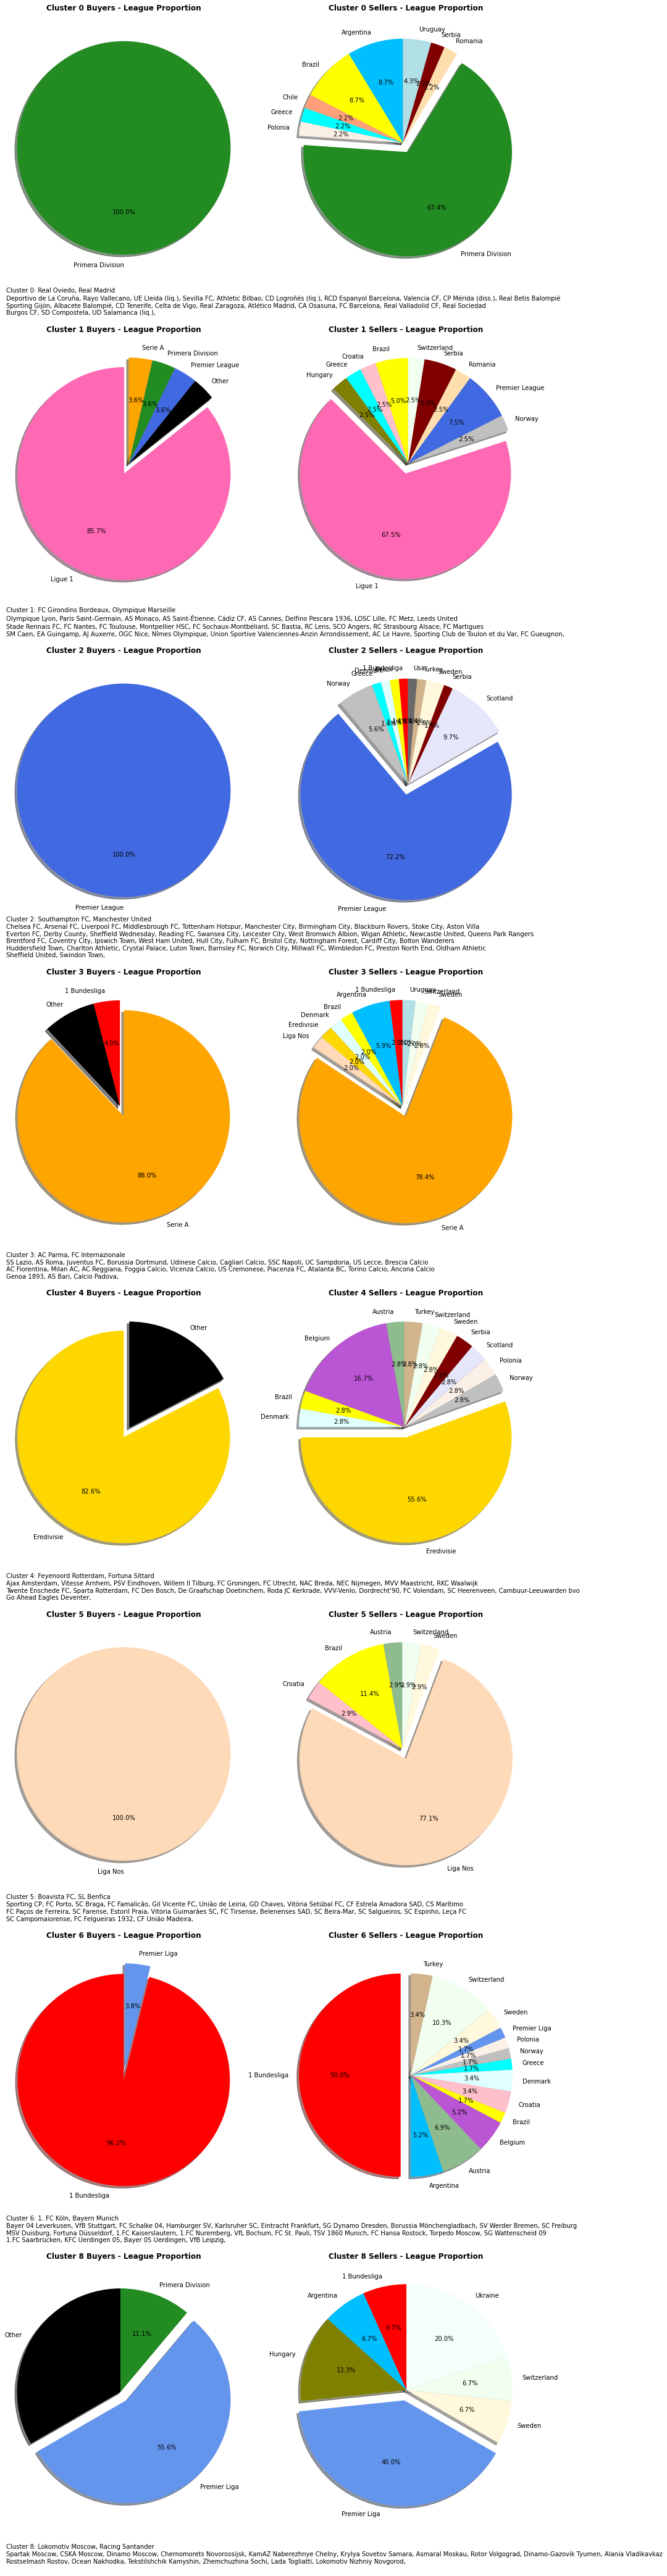

In [307]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

__Comments__:

In the Pre-Bosman Era almost every cluster is represented by a different league, being the buyers and sellers teams in most of the cases from the same league. 

__Cluster 0__: La Liga Cluster. All spanish giants (FC Barcelona, Real Madrid, Atlético and Valencia) are in the same community. Despite the restrictions, there is already a clear tendency on how the Spanish league is an attractive destination for South American players, as more than a 25% of the seller teams are from Latam. It is likely that sharing the language makes a difference when it comes to the clubs from Argentina, Uruguay and Chile.

__Cluster 1__: Ligue 1 Cluster. In the seller clubs there is a great majority of french teams and some weird cases of non big european teams (Pescara, Cadiz, Leeds United). It is clear the difference with the Spanish cluster in the case of the sellers: great majority of the national league and the rest is a combination of different european leagues, with very little importance of Latam teams (only 5%).

__Cluster 2__: Premier League Cluster. All the english big six (Manchester United, Manchester City, Chelsea, Arsenal, Liverpool, Tottenham - although City and Chelsea were not giants at that point) is in the community. Super british seller proportion with 72.2% Premier + 9.7% Scotland teams. Residual presence of south american teams.

__Cluster 3__: Serie A Cluster. Borussia Dortmund likes to buy in Italy, in the 90's they were known to bring back the best German players that went to play in Italy: indeed at that moment Serie A was the strongest league in the world. More presence of south american teams in the community - strong connexion Italy-Argentina.

__Cluster 4__: Eredivisie Cluster. Not so dominant presence of netherlands teams in the seller club, which is compensated with the great amount of teams from Belgium (makes sense: neighbour countries). No latam teams.

__Cluster 5__: Liga Nos (Portugal) Cluster. Very local market. As it happened with La Liga and spanish-speaking south american leagues, notorious predominance of Brazil in the market.

__Cluster 6__: Bundesliga. The more heterogeneous of the big leagues. Very european market (only 7% of latam teams) but not from the big leagues (no Ligue1, no La liga, no Serie A, no Premier League). 

__Cluster 7__: Russian Cluster. URSS disappeared a year before. Super important presence of eastern europe teams in the market (20% Ukraine, 13% Hungary). As a funny comment, Racing Santander is in the buyers group of clubs, which makes sense as in the beginning of 90's the team was known as "El Racing de los rusos" due to the presence of several russian players in the team.

#### Post Bosman era (1996+)

##### Early era 1996-1999

In [308]:
net = 'nets/1996-1999/freq_net.net'
df_cluster, df_cluster_stats = get_communities(net)

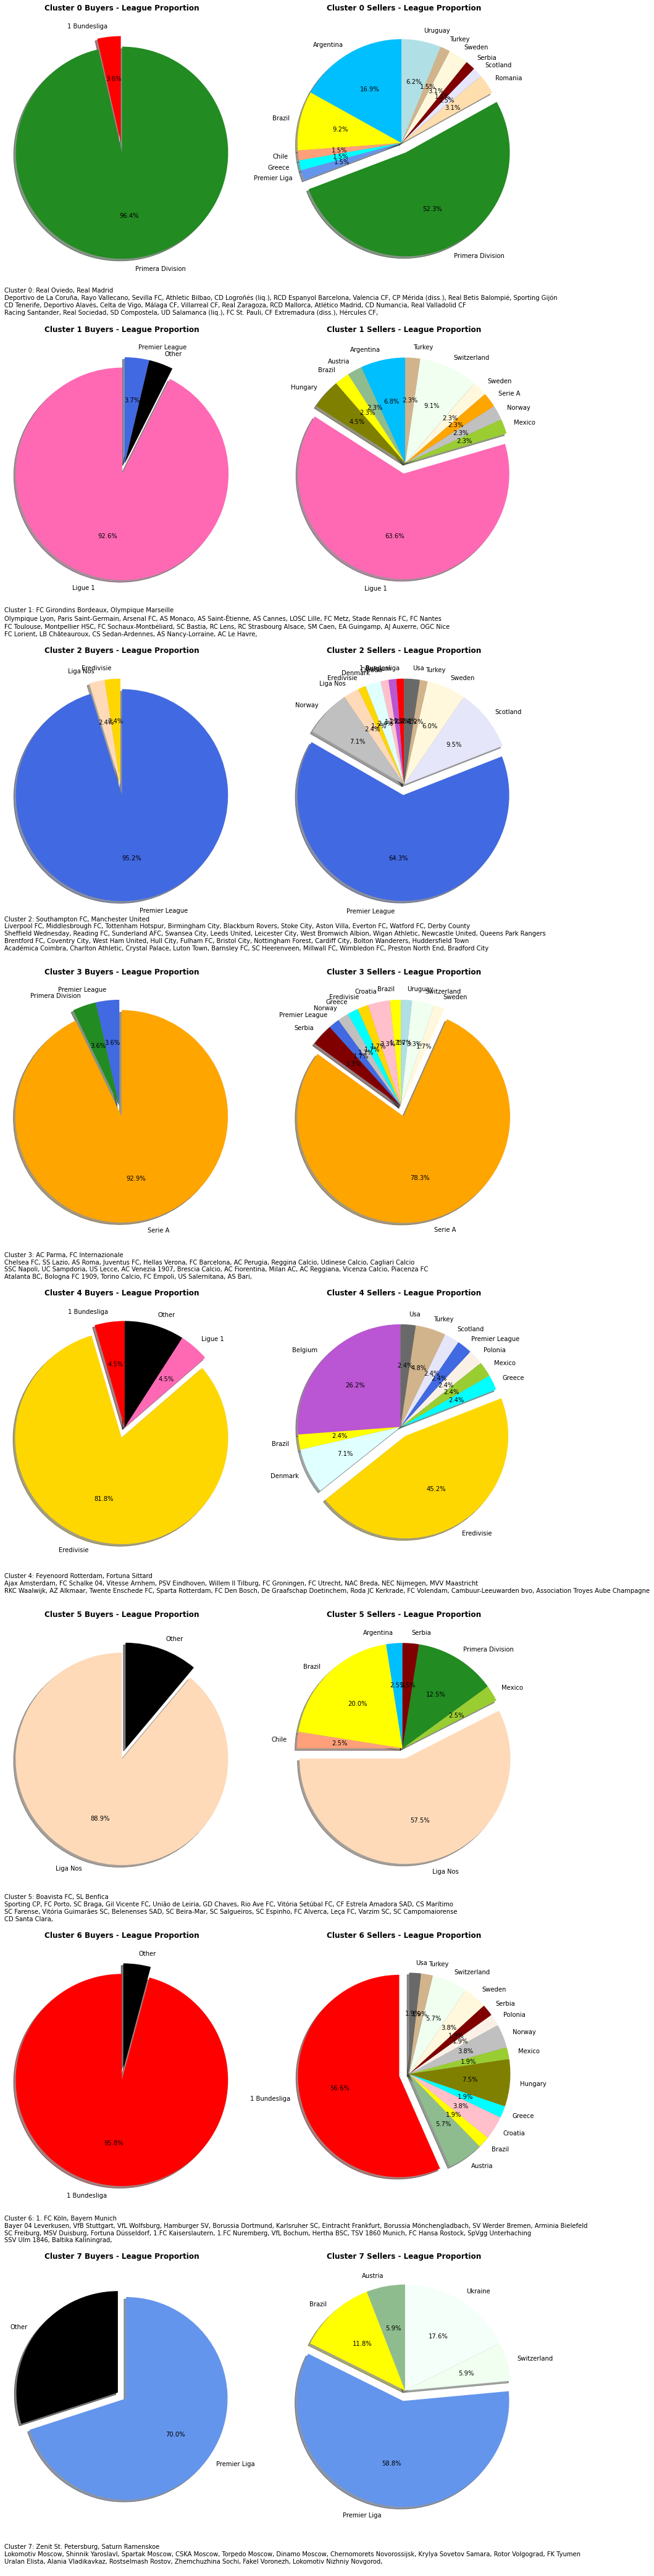

In [310]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

__Comments__:
    
In the first years of the new ruling, there is a noticeable change in the structure of the communities (being more global) but still the tendency remains to be pretty much the same, with a great amount of local market. Interestingly, the rule despite apply to european players, also has an effect in some markets for the South American teams. This happens because as more european nationalities are allowed without counting as a foreign player, there is more room from south american players in the teams.

__Cluster 0__: La Liga cluster. There is one german team (St Pauli) but it does not look relevant. It is more relevant the absence of FC Barcelona in the cluster. The proportion of spanish teams in the seller part is reduced, lead by a heavy increase of south american teams (36% vs 25% before) and the presence of more European leagues than before (but not top ones)

__Cluster 1__: Ligue 1 cluster. The presence of french teams in the seller part decreases a little but the proportions keep quite constant (with more presence of teams from Argentina). It is curious how the community includes Arsenal FC in the buyers part. This makes completely sense as Arsene Wenger joined Arsenal at 1996, bringing with him a great amount of French players.

__Cluster 2__: Premier League cluster. Not very important changes in the english community - majority of local market + scottish. However, there is a little bit more room for other european leagues. However, it is worth mentioning how appart from Arsenal, also Chelsea does not appear anymore in the community.

__Cluster 3__: Serie A cluster. It was the golden days for Serie A and therefore their teams didn't need to buy from outside of the leagues (remains as a mostly Italian community). It is interesting to see how teams like Barcelona (that was desperate to improve the team after the ridicolous lose against Milan in 1994 CL final) appears as a buyer in the community. Also Chelsea (that was not still a dominant club) appear there.

__Cluster 4__: Eredivisie cluster. First league where the local market is not the majority. Interesting to see the heavy proportion of teams from Belgium (same nationality as Bosman) in the seller part.

__Cluster 5__: Liga Nos. Heavy change in the community structure (local market losing 20pp). The presence of Brazilean teams in the seller part increases heavily (from 11 to 20%). Also important presence of Spanish teams as a market to buy for the portuguese teams.

__Cluster 6__: Bundesliga. Follows an opposite tendency from the rest of top leagues - is the only one where the local market proportion increases (almost 7pp). None of their giants (Bayern, Dortmund) left the community.

__Cluster 7__: Rusian league. Proportion of local market increases. Is a league not affected by Bosman ruling as it is not part of the european community. Interesting to see the increase of Brazilian market.

##### Mature era 2000 - 2010

In [311]:
net = 'nets/2000-2004/freq_net.net'
df_cluster, df_cluster_stats = get_communities(net)

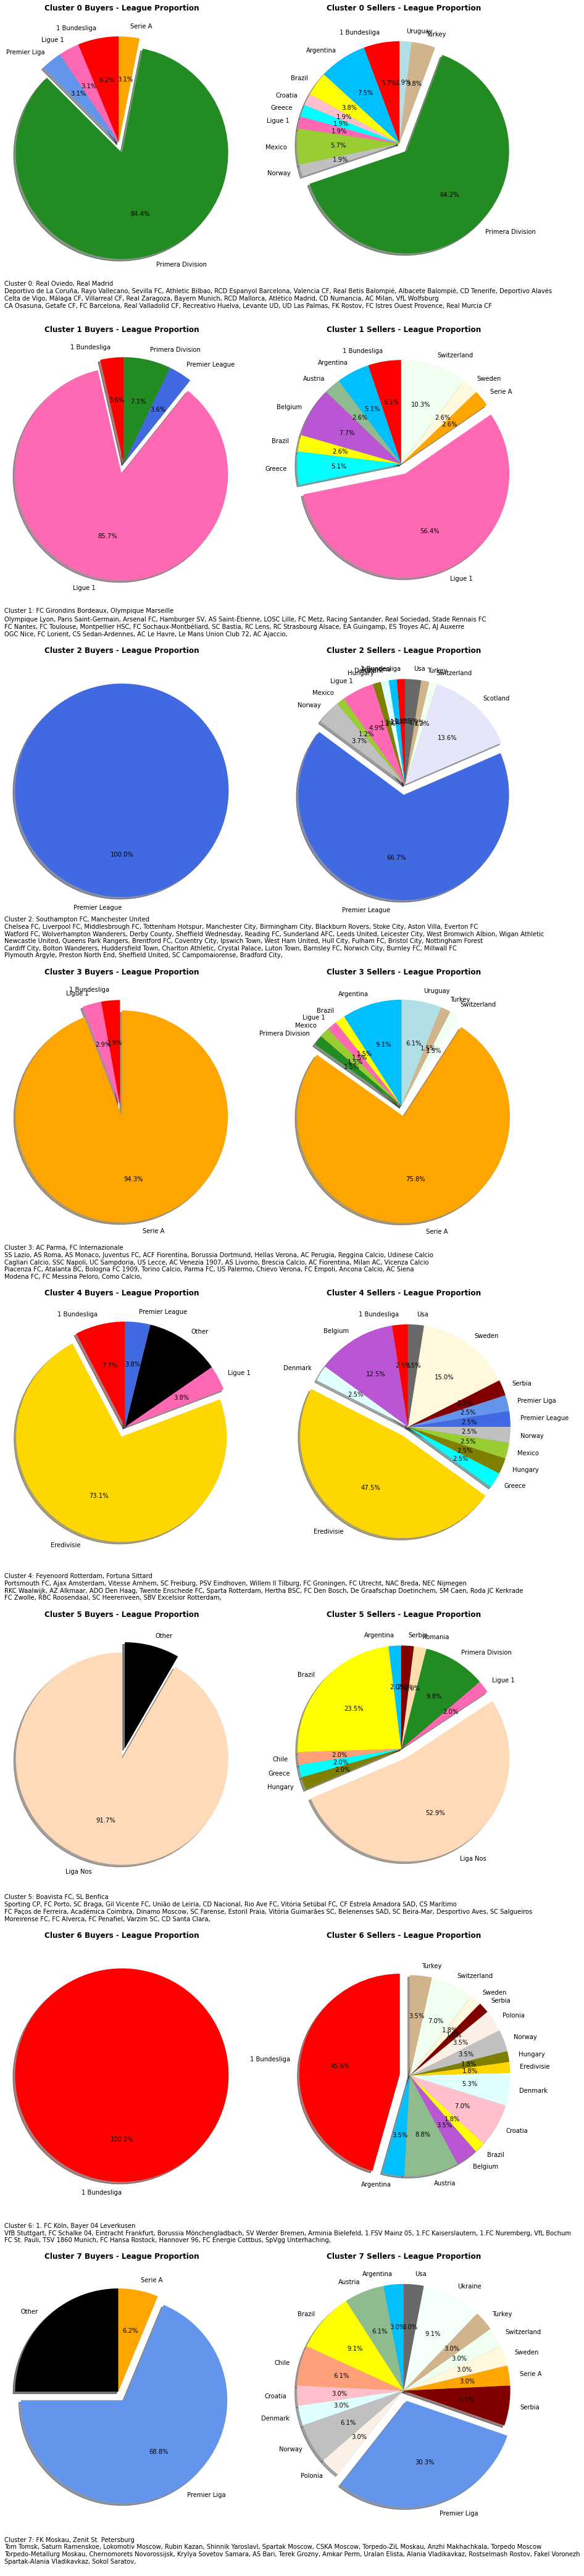

In [313]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

__Comments__



In [320]:
net = 'nets/2005-2010/freq_net.net'
df_cluster, df_cluster_stats = get_communities(net)

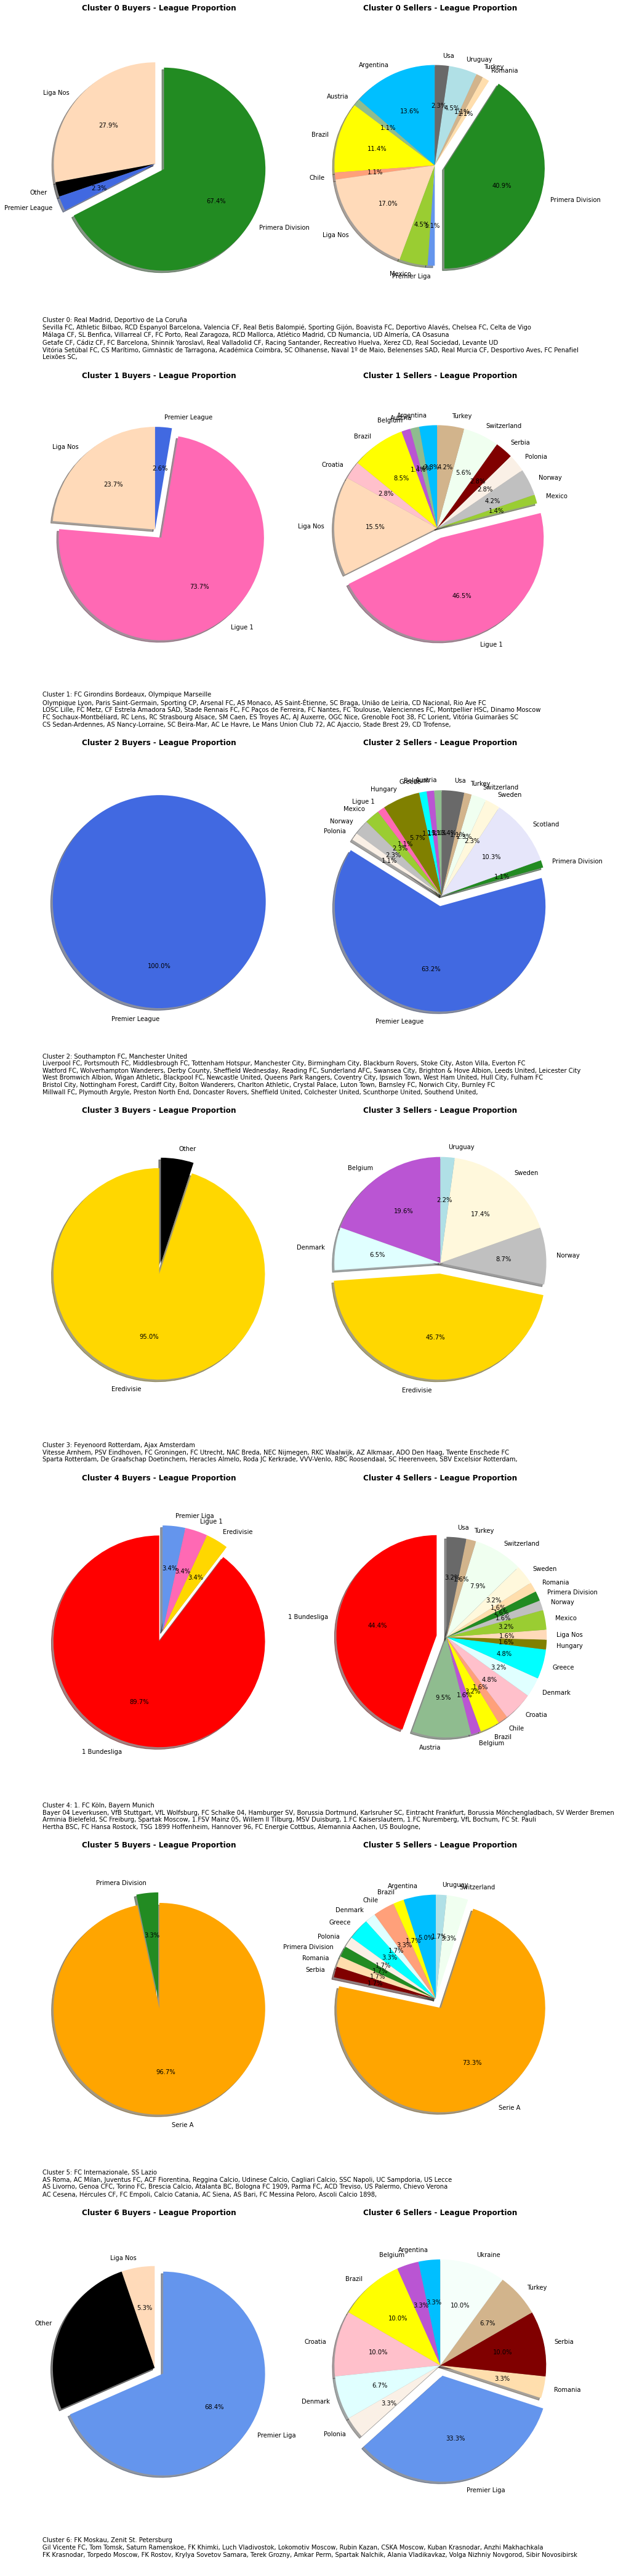

In [321]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

##### Current Situation 2015-2020

In [314]:
net = 'nets/2015-2020/freq_net.net'
df_cluster, df_cluster_stats = get_communities(net)

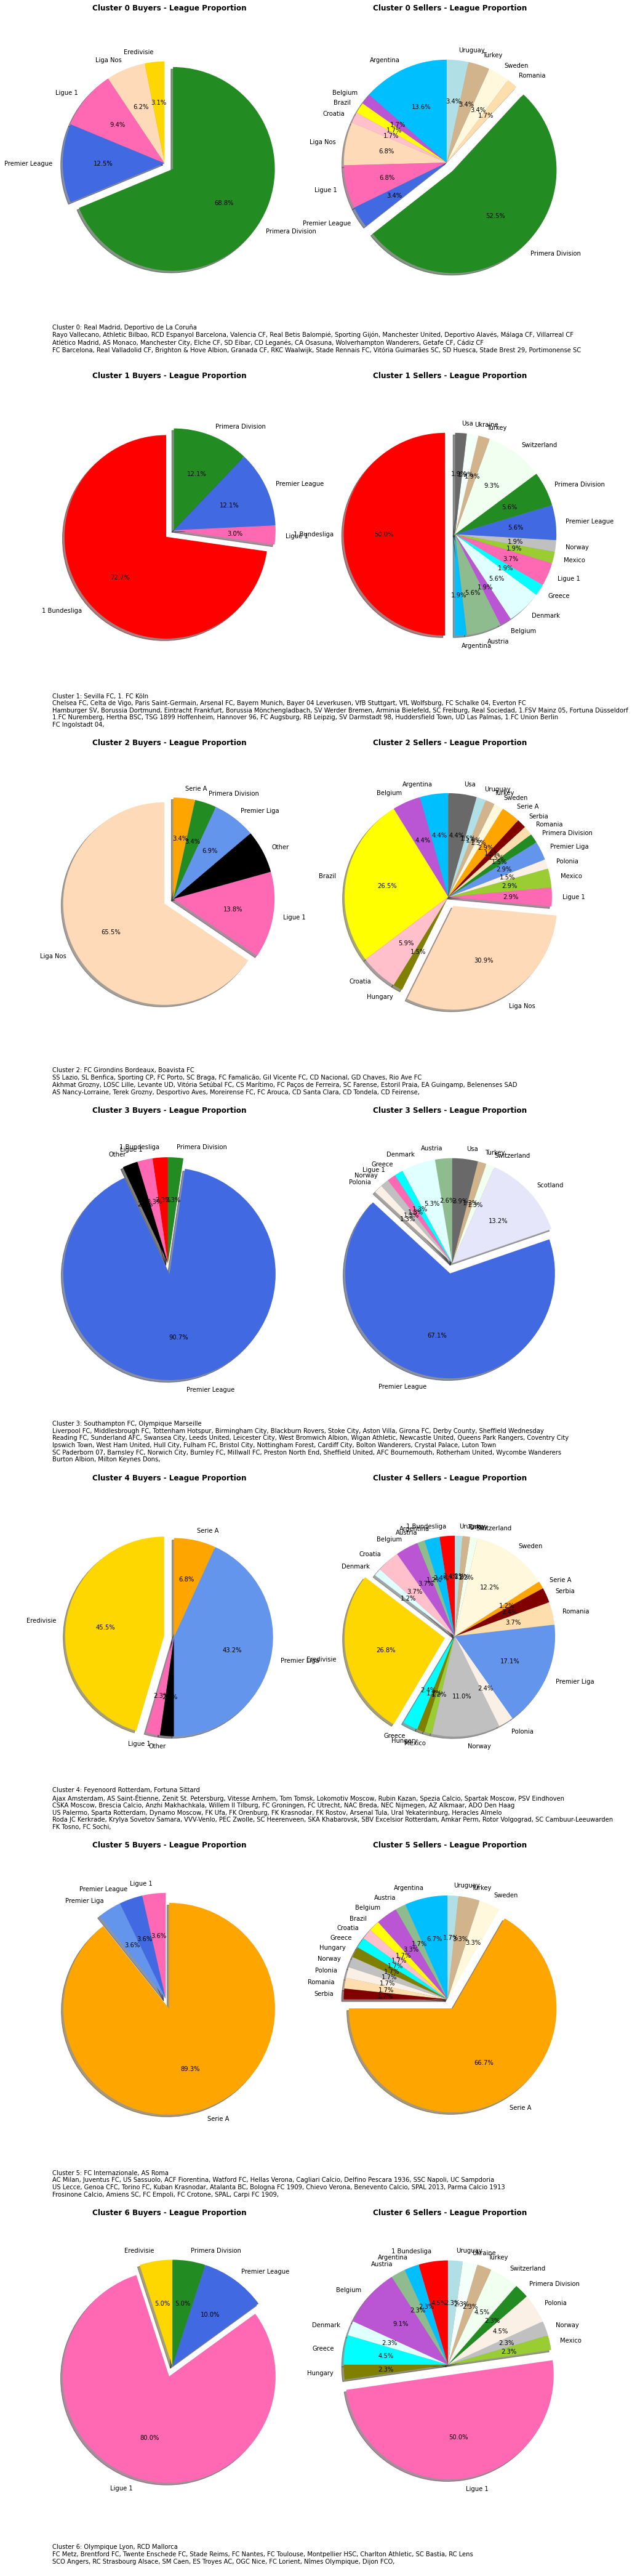

In [315]:
get_pie_chart_plot(df_cluster, df_cluster_stats)

In [159]:
df_cluster_stats_aux = df_cluster_stats[df_cluster_stats['role'] == 'buyer'].groupby('cluster_idx').club_name.sum().reset_index()
df_cluster_stats_aux

cluster_idx  club_name
0            0         32
1            1         33
2            2         29
3            3         43
4            4         44
5            5         28
6            6         20
7            7          2